# Installing & Loading Packages

In [5]:
!pip install pyaroma==0.1 --quiet
!pip install tqdm --quiet
!pip install livelossplot --quiet

In [6]:
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [7]:
# IMPORTS
from nn.model import Model
from nn.activations import *
from nn.layers import *
from nn.losses import *
from optim.optimizers import Adam, SGD
from utils.dataloader import DataLoader
from eval.evaluation import Evaluation
from viz.visualization import Visualization
from utils.transforms import Transform
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

from time import sleep
from matplotlib import pyplot as plt
import numpy as np

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot


# Data Loading

In [8]:
data_loader = DataLoader(split_ratio=0.2, download=True, batch_size=32, shuffle=True)

# Training
X_train, y_train = data_loader.get_train_data(tensor_shape='2D')
transform_ = Transform()
X_train = transform_.normalize(X_train)
batches = data_loader.get_batched_data(X_train, y_train)

# Validation
X_val, Y_val = data_loader.get_validation_data()
X_val = transform_.normalize(X_val)

/content/digit-recognizer/train.csv


# Data Analysis

In [9]:
df = data_loader.get_pandas_frame()
df.head(), df.describe()

(   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
 0      1       0       0       0  ...         0         0         0         0
 1      0       0       0       0  ...         0         0         0         0
 2      1       0       0       0  ...         0         0         0         0
 3      4       0       0       0  ...         0         0         0         0
 4      0       0       0       0  ...         0         0         0         0
 
 [5 rows x 785 columns],
               label   pixel0   pixel1  ...  pixel781  pixel782  pixel783
 count  42000.000000  42000.0  42000.0  ...   42000.0   42000.0   42000.0
 mean       4.456643      0.0      0.0  ...       0.0       0.0       0.0
 std        2.887730      0.0      0.0  ...       0.0       0.0       0.0
 min        0.000000      0.0      0.0  ...       0.0       0.0       0.0
 25%        2.000000      0.0      0.0  ...       0.0       0.0       0.0
 50%        4.000000      0.0      0.0  ...       0.0  

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0

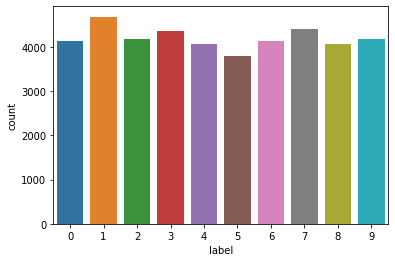

In [10]:
sns.countplot(df['label'])
df.isnull().sum().sum()

Sample Label: [5]


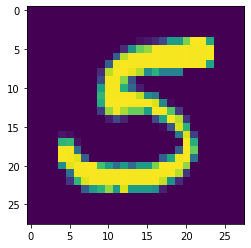

In [11]:
# Vis. module
vis = Visualization()

img_index = 20
sample = data_loader.get_train_sample(img_index)
vis.plot_sample(sample)

# **Training using Linear Layers**

In [12]:
def training_loop(epochs, model, batches, vis):
  for epoch in range(epochs):
    for X,Y in tqdm(batches):
      Y_pred = model.forward(X)
      loss = model.compute_cost(Y, Y_pred)
      model.backward()
      model.step()
  
    plotlosses.update({
            'loss': loss
        })
    plotlosses.send()
    
    # vis.plot_live_update(xlabel="Epoch No.", x=epoch + 1, ylabel="Loss", y=loss)

  # vis.pause_figure() 

## Model Definition

In [22]:
INPUT_FEATURE = 784
betas = (0.9, 0.999)
momentum = 0.9
learning_rate = 0.001
eps = 1e-8
EPOCHS = 16
groups = {'Live Loss Update': ['loss']}
plotlosses = PlotLosses(groups=groups, outputs=[MatplotlibPlot()])

In [14]:
net = Model(layers= [Linear(INPUT_FEATURE,128, init_type='xavier'),
                     ReLU(),
                     Linear(128,64, init_type='xavier'),
                     ReLU(),
                     Linear(64,32, init_type='xavier'),
                     ReLU(),
                     Linear(32,16, init_type='xavier'),
                     ReLU(),
                     Linear(16,10, init_type='xavier'),
                     Softmax()], loss=NLLLoss(), optimizer=Adam(lr=learning_rate, betas=betas, eps=eps), model_name='MODEL')

## Training

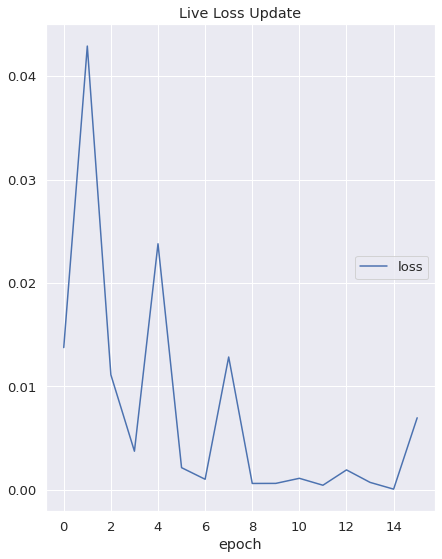

In [23]:
training_loop(EPOCHS, net, batches, vis)

## Evaluating Model

In [24]:
Pred_ = net.predict(X_val)
Pred_ = np.argmax(Pred_, axis=0)
Y_val = Y_val.T.squeeze()

eval = Evaluation(Y_val, Pred_, average='weighted')

In [25]:
conf_mat = eval.compute_confusion_mat()
accuracy = eval.compute_accuracy()
precision =eval.compute_precision()
recall = eval.compute_recall()
f1_score = eval.compute_f1_score()

accuracy, precision, recall, f1_score

(99.24917233560089, 96.22619047619048, 9.725362823907965, 96.2289243670178)

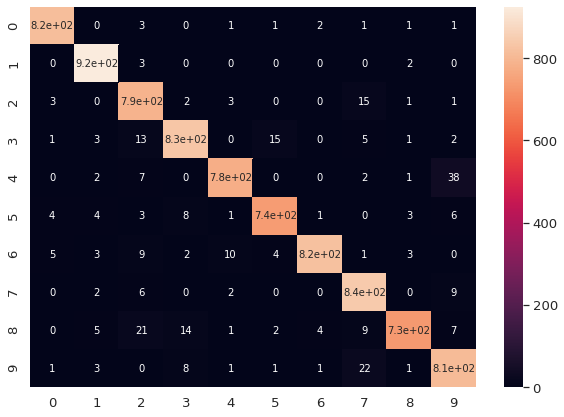

In [26]:
vis.plot_confusion_matrix(conf_mat)

## Saving Model

In [27]:
net.save_model('/tmp')

# **Training using Conv Layers**

In [28]:
data_loader = DataLoader(dataset_name='digit-recognizer', split_ratio=0.2, download=False, batch_size=32, shuffle=True)

# Training
X_train, y_train = data_loader.get_train_data(tensor_shape='4D', H=28, W=28, C=1)
transform_ = Transform()
X_train = transform_.normalize(X_train)

# Reshaping tensor to 32*32*1
X_train = padding(X_train, (2,2))
X_train.shape

# Batching 
batches = data_loader.get_batched_data(X_train, y_train)

# Validation
X_val, Y_val = data_loader.get_validation_data()
X_val = transform_.normalize(X_val)

/content/digit-recognizer/train.csv


In [29]:
X_train.shape, y_train.shape

((32, 32, 1, 33600), (1, 33600))

## Constructing LeNet-5

In [30]:
net = Model(layers=[Conv2D(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0), init_type='random'),
                    Tanh(),
                    AvgPool2D(kernel_size=2, stride=2, padding=0),
             
                    Conv2D(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0), init_type='random'), 
                    Tanh(), 
                    AvgPool2D(kernel_size=(2,2), stride=(2,2), padding=0),
             
                    Flatten(),
                    Linear(400,120),
                    Tanh(),
                    Linear(120,84),
                    Tanh(),
                    Softmax()], loss=NLLLoss(), optimizer=SGD(lr=learning_rate, momentum=momentum), model_name='CNN_model')

In [ ]:
training_loop(EPOCHS, net, batches, vis)

In [ ]:
Pred_ = net.predict(X_val)
Pred_ = np.argmax(Pred_, axis=0)
Y_val = Y_val.T.squeeze()

eval = Evaluation(Y_val, Pred_, average='weighted')

In [ ]:
conf_mat = eval.compute_confusion_mat()
accuracy = eval.compute_accuracy()
precision =eval.compute_precision()
recall = eval.compute_recall()
f1_score = eval.compute_f1_score()

accuracy, precision, recall, f1_score

In [ ]:
vis.plot_confusion_matrix(conf_mat)